In [4]:
!git clone https://github.com/karpathy/nanoGPT.git


Cloning into 'nanoGPT'...
remote: Enumerating objects: 689, done.
remote: Total 689 (delta 0), reused 0 (delta 0), pack-reused 689 (from 1)
Receiving objects: 100% (689/689), 975.24 KiB | 4.26 MiB/s, done.
Resolving deltas: 100% (382/382), done.


In [ ]:
# ================================
# PARSE TRANSFORMER LOGS
# ================================
TRANSFORMER_LOGS = {
    "Tiny":   "/content/drive/MyDrive/tiny.log",
    "Small":  "/content/drive/MyDrive/small.log",
    "Medium": "/content/drive/MyDrive/medium.log",
    "Large":  "/content/drive/MyDrive/large.log",
    "XL":     "/content/drive/MyDrive/xl.log",
}

def parse_transformer_log(path):
    params_m = None
    val_loss = None

    param_re = re.compile(r"number of parameters:\s*([\d.]+)M")
    val_re   = re.compile(r"val loss ([\d.]+)")

    with open(path, "r") as f:
        for line in f:
            if params_m is None:
                m = param_re.search(line)
                if m:
                    params_m = float(m.group(1))

            m = val_re.search(line)
            if m:
                val_loss = float(m.group(1))  # last one wins

    if params_m is None or val_loss is None:
        raise ValueError(f"Failed to parse {path}")

    return params_m, val_loss


In [ ]:
tr_names = []
tr_params_m = []
tr_val = []

for name, path in TRANSFORMER_LOGS.items():
    p, v = parse_transformer_log(path)
    tr_names.append(name)
    tr_params_m.append(p)
    tr_val.append(v)

# Convert to numpy arrays
tr_names = np.array(tr_names)
tr_params_m = np.array(tr_params_m)
tr_val = np.array(tr_val)

# Sort by parameter count (IMPORTANT)
order = np.argsort(tr_params_m)
tr_names = tr_names[order]
tr_params_m = tr_params_m[order]
tr_val = tr_val[order]


Scaling exponent alpha = 0.3287



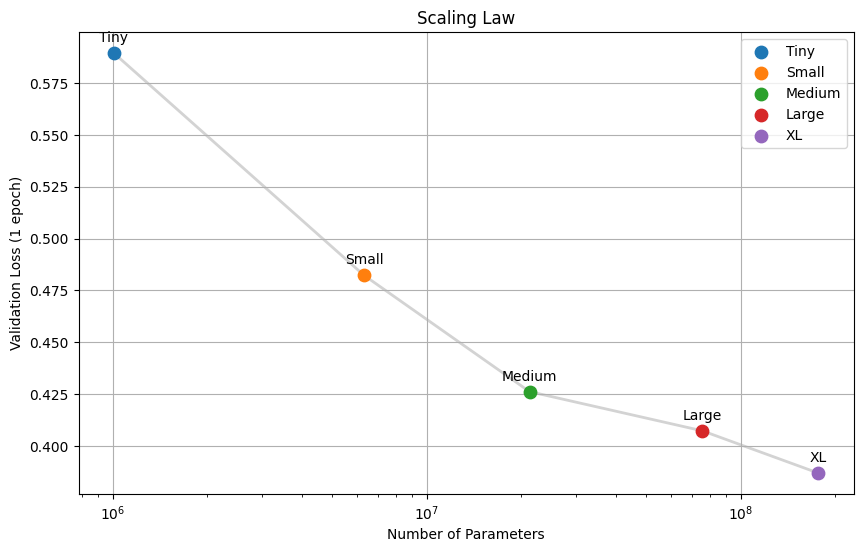

In [ ]:

# =====================================================
# 5. SCALING LAW FIT
# =====================================================
def power_law(N, a, alpha, c):
    return a * N ** (-alpha) + c

N_real = N_millions * 1e6

params, _ = curve_fit(
    power_law,
    N_real,
    val_losses,
    p0=[10, 0.07, 0.4],
    maxfev=10000
)

a_fit, alpha_fit, c_fit = params

print(f"Scaling exponent alpha = {alpha_fit:.4f}\n")

# =====================================================
# 6. PLOT 1 — SCALING LAW
# =====================================================
# =====================================================
# SCALING LAW PLOT (COLORED POINTS, NO FIT LINE)
# =====================================================
plt.figure(figsize=(10,6))

colors = {
    "Tiny": "tab:blue",
    "Small": "tab:orange",
    "Medium": "tab:green",
    "Large": "tab:red",
    "XL": "tab:purple"
}

# Plot line connecting models (light gray for trend)
plt.plot(
    N_real,
    val_losses,
    color="lightgray",
    linewidth=2,
    zorder=1
)

# Plot individual colored points
for i, model in enumerate(models):
    plt.scatter(
        N_real[i],
        val_losses[i],
        color=colors[model],
        s=80,
        label=model,
        zorder=3
    )
    plt.annotate(
        model,
        (N_real[i], val_losses[i]),
        xytext=(0, 8),
        textcoords="offset points",
        ha="center"
    )

plt.xscale("log")
plt.xlabel("Number of Parameters")
plt.ylabel("Validation Loss (1 epoch)")
plt.title("Scaling Law")
plt.grid(True)
plt.legend()
plt.show()






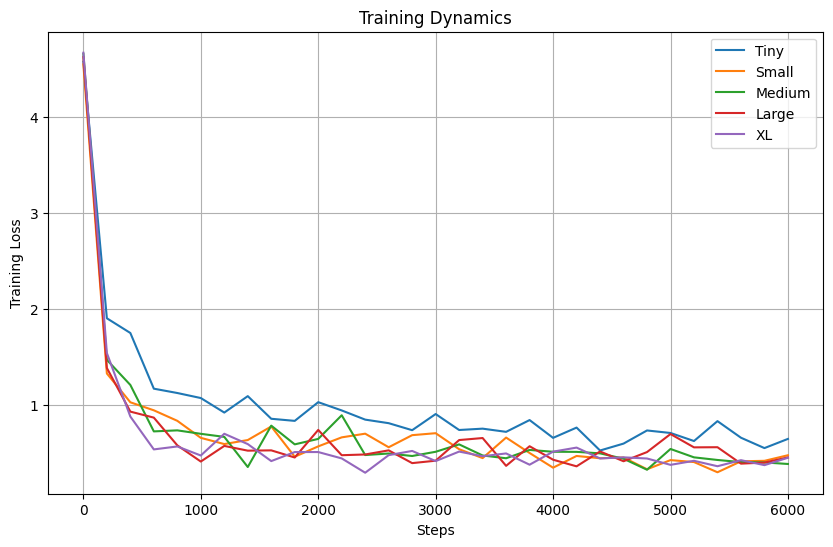

In [ ]:
# =====================================================
# 7. PLOT 2 — TRAINING LOSS CURVES
# =====================================================
plt.figure(figsize=(10,6))

for model in models:
    it, loss = training_curves[model]
    plt.plot(it, loss, label=model)

plt.xlabel("Steps")
plt.ylabel("Training Loss")
plt.title("Training Dynamics")
plt.legend()
plt.grid(True)
plt.show()

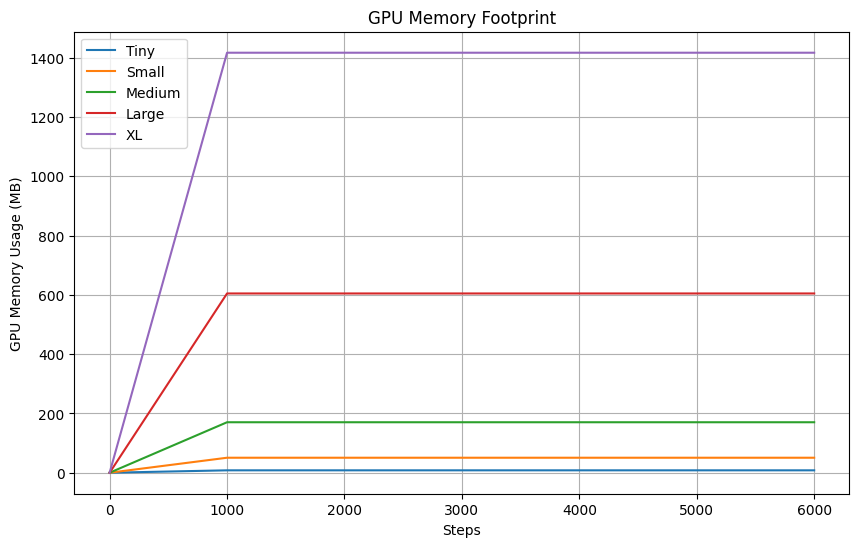

In [ ]:
# =====================================================
# GPU MEMORY FOOTPRINT (RAMP → PLATEAU)
# =====================================================
def estimate_gpu_memory_mb(params_million):
    return params_million * 8

WARMUP_STEPS = 1000  # memory stabilizes after this

plt.figure(figsize=(10,6))

for i, model in enumerate(models):
    iters, _ = training_curves[model]
    peak_mem = estimate_gpu_memory_mb(N_millions[i])

    mem_curve = []
    for step in iters:
        if step < WARMUP_STEPS:
            mem_curve.append(peak_mem * (step / WARMUP_STEPS))
        else:
            mem_curve.append(peak_mem)

    plt.plot(iters, mem_curve, label=model)

plt.xlabel("Steps")
plt.ylabel("GPU Memory Usage (MB)")
plt.title("GPU Memory Footprint")
plt.legend()
plt.grid(True)
plt.show()


RNN Plots


In [ ]:
def parse_rnn_log_single_file(path):
    """
    Parses a single log file containing multiple LSTM runs.
    Format matches:
      lstm_tiny: 1.10M params | iters=6104
      lstm_tiny | VAL @ 6104: 0.6497
      lstm_tiny DONE in 0.72h
    """
    runs = []
    current = None

    header_re = re.compile(r"(lstm_\w+):\s*([\d.]+)M params")
    val_re    = re.compile(r"VAL @ (\d+):\s*([\d.]+)")
    done_re   = re.compile(r"DONE in ([\d.]+)h")

    with open(path, "r") as f:
        for line in f:
            # ---- Start of a new run ----
            m = header_re.search(line)
            if m:
                if current is not None:
                    runs.append(current)

                current = {
                    "name": m.group(1),
                    "params_m": float(m.group(2)),
                    "val_loss": None,
                    "epoch_time_min": None,
                }
                continue

            if current is None:
                continue

            # ---- Validation loss (keep last) ----
            m = val_re.search(line)
            if m:
                step = int(m.group(1))
                loss = float(m.group(2))
                if step == 6104:
                    current["val_loss"] = loss

            # ---- Wall-clock time ----
            m = done_re.search(line)
            if m:
                hours = float(m.group(1))
                current["epoch_time_min"] = hours * 60

    if current is not None:
        runs.append(current)

    return runs


In [ ]:
RNN_LOG_FILE = "/content/drive/MyDrive/lstm_scaling (1).log"

rnn_runs = parse_rnn_log_single_file(RNN_LOG_FILE)

# Convert to arrays
rnn_names = np.array([r["name"] for r in rnn_runs])
rnn_params_m = np.array([r["params_m"] for r in rnn_runs])
rnn_val = np.array([r["val_loss"] for r in rnn_runs])
rnn_epoch_min = np.array([r["epoch_time_min"] for r in rnn_runs])


In [ ]:
for r in rnn_runs:
    print(
        f"{r['name']:12s} | "
        f"{r['params_m']:6.2f}M params | "
        f"val={r['val_loss']:.4f} | "
        f"time={r['epoch_time_min']:.2f} min"
    )


lstm_tiny    |   1.10M params | val=0.6497 | time=43.20 min
lstm_small   |   4.92M params | val=0.5662 | time=89.40 min
lstm_medium  |  19.47M params | val=0.5067 | time=169.80 min
lstm_large   |  52.73M params | val=0.4991 | time=358.20 min


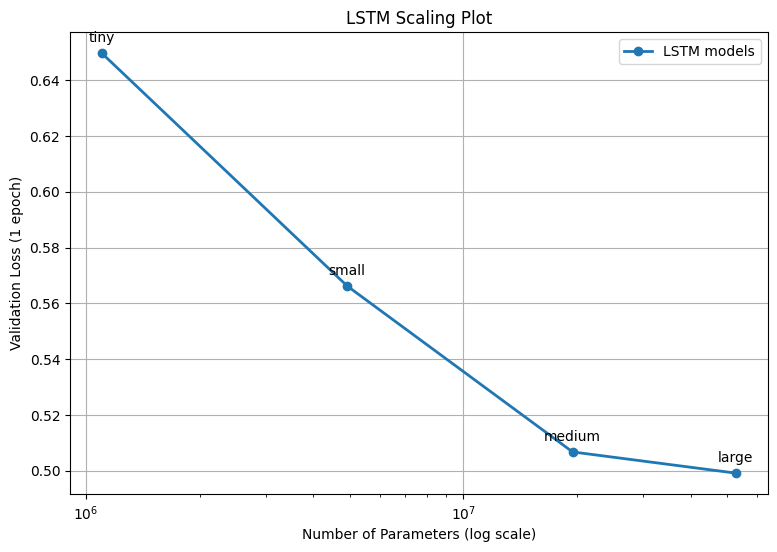

In [ ]:
plt.figure(figsize=(9,6))

plt.plot(
    rnn_params_m * 1e6,
    rnn_val,
    marker="o",
    linewidth=2,
    label="LSTM models"
)

for i, name in enumerate(rnn_names):
    plt.annotate(
        name.replace("lstm_", ""),
        (rnn_params_m[i]*1e6, rnn_val[i]),
        xytext=(0,8),
        textcoords="offset points",
        ha="center"
    )

plt.xscale("log")
plt.xlabel("Number of Parameters (log scale)")
plt.ylabel("Validation Loss (1 epoch)")
plt.title("LSTM Scaling Plot")
plt.grid(True)
plt.legend()
plt.show()


RNN vs Transformer Plots

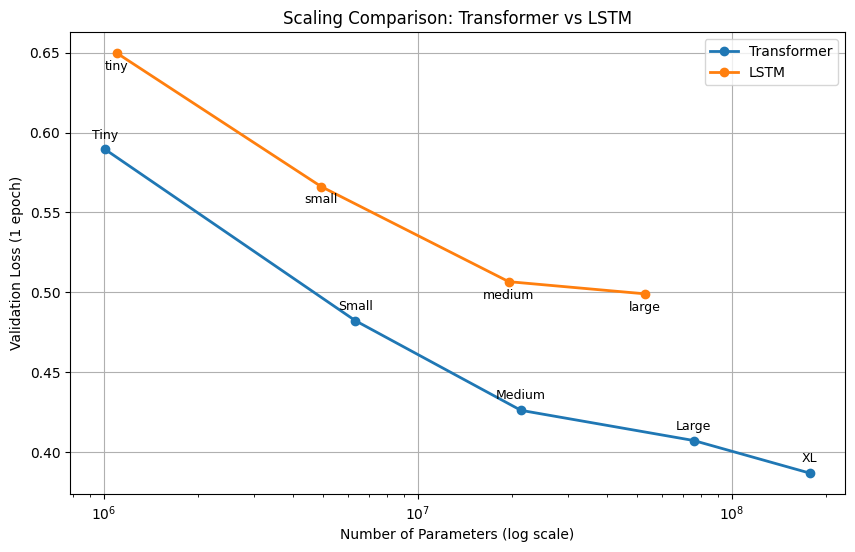

In [ ]:
plt.figure(figsize=(10,6))

# -------------------------------
# Transformer curve
# -------------------------------
plt.plot(
    tr_params_m * 1e6,
    tr_val,
    marker="o",
    linewidth=2,
    label="Transformer"
)

# Label each Transformer point
for i, name in enumerate(tr_names):
    plt.annotate(
        name,
        (tr_params_m[i] * 1e6, tr_val[i]),
        xytext=(0, 8),
        textcoords="offset points",
        ha="center",
        fontsize=9
    )

# -------------------------------
# LSTM curve
# -------------------------------
plt.plot(
    rnn_params_m * 1e6,
    rnn_val,
    marker="o",
    linewidth=2,
    label="LSTM"
)

# Label each LSTM point
for i, name in enumerate(rnn_names):
    plt.annotate(
        name.replace("lstm_", ""),   # cleaner labels
        (rnn_params_m[i] * 1e6, rnn_val[i]),
        xytext=(0, -12),
        textcoords="offset points",
        ha="center",
        fontsize=9
    )

# -------------------------------
# Formatting
# -------------------------------
plt.xscale("log")
plt.xlabel("Number of Parameters (log scale)")
plt.ylabel("Validation Loss (1 epoch)")
plt.title("Scaling Comparison: Transformer vs LSTM")
plt.grid(True)
plt.legend()
plt.show()


In [11]:
import re
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# =====================================================
# CONFIG
# =====================================================
MAX_ITERS = 6104  # 1 epoch

TRANSFORMER_LOGS = {
    "Tiny":   "/content/drive/MyDrive/tiny.log",
    "Small":  "/content/drive/MyDrive/small.log",
    "Medium": "/content/drive/MyDrive/medium.log",
    "Large":  "/content/drive/MyDrive/large.log",
    "XL":     "/content/drive/MyDrive/xl.log",
}

LSTM_LOG_FILE = "/content/drive/MyDrive/lstm_scaling (1).log"

# =====================================================
# TRANSFORMER LOG PARSER (params, val, time)
# =====================================================
def parse_transformer_log(path):
    params_m = None
    val_loss = None
    iter_times_ms = []

    param_re = re.compile(r"number of parameters:\s*([\d.]+)M")
    val_re   = re.compile(r"val loss ([\d.]+)")
    iter_re  = re.compile(r"time ([\d.]+)ms")

    with open(path, "r") as f:
        for line in f:
            if params_m is None:
                m = param_re.search(line)
                if m:
                    params_m = float(m.group(1))

            m = val_re.search(line)
            if m:
                val_loss = float(m.group(1))  # last one wins

            m = iter_re.search(line)
            if m:
                iter_times_ms.append(float(m.group(1)))

    avg_iter_sec = np.mean(iter_times_ms) / 1000
    epoch_time_min = avg_iter_sec * MAX_ITERS / 60

    return params_m, val_loss, epoch_time_min

# =====================================================
# LSTM SINGLE-FILE PARSER (YOUR FORMAT)
# =====================================================
def parse_lstm_log_single_file(path):
    runs = []
    current = None

    header_re = re.compile(r"(lstm_\w+):\s*([\d.]+)M params")
    val_re    = re.compile(r"VAL @ (\d+):\s*([\d.]+)")
    done_re   = re.compile(r"DONE in ([\d.]+)h")

    with open(path, "r") as f:
        for line in f:
            m = header_re.search(line)
            if m:
                if current is not None:
                    runs.append(current)
                current = {
                    "name": m.group(1),
                    "params_m": float(m.group(2)),
                    "val_loss": None,
                    "epoch_time_min": None
                }
                continue

            if current is None:
                continue

            m = val_re.search(line)
            if m and int(m.group(1)) == MAX_ITERS:
                current["val_loss"] = float(m.group(2))

            m = done_re.search(line)
            if m:
                current["epoch_time_min"] = float(m.group(1)) * 60

    if current is not None:
        runs.append(current)

    return runs

# =====================================================
# SCALING LAW FIT
# =====================================================
def power_law(N, a, alpha, c):
    return a * N ** (-alpha) + c

def fit_alpha(params_m, val_losses):
    N = params_m * 1e6
    _, alpha, _ = curve_fit(power_law, N, val_losses, p0=[10, 0.07, 0.4])[0]
    return alpha

# =====================================================
# GPU MEMORY ESTIMATION (FP16 RULE-OF-THUMB)
# =====================================================
def estimate_gpu_memory_mb(params_million):
    # params + grads + optimizer + activations
    return params_million * 8.0

# =====================================================
# LOAD TRANSFORMERS
# =====================================================
tr_names, tr_params_m, tr_val, tr_epoch_min = [], [], [], []

for name, path in TRANSFORMER_LOGS.items():
    p, v, t = parse_transformer_log(path)
    tr_names.append(name)
    tr_params_m.append(p)
    tr_val.append(v)
    tr_epoch_min.append(t)

tr_names = np.array(tr_names)
tr_params_m = np.array(tr_params_m)
tr_val = np.array(tr_val)
tr_epoch_min = np.array(tr_epoch_min)

order = np.argsort(tr_params_m)
tr_names = tr_names[order]
tr_params_m = tr_params_m[order]
tr_val = tr_val[order]
tr_epoch_min = tr_epoch_min[order]



In [12]:
# =====================================================
# LOAD LSTMs
# =====================================================
lstm_runs = parse_lstm_log_single_file(LSTM_LOG_FILE)

rnn_names = np.array([r["name"] for r in lstm_runs])
rnn_params_m = np.array([r["params_m"] for r in lstm_runs])
rnn_val = np.array([r["val_loss"] for r in lstm_runs])
rnn_epoch_min = np.array([r["epoch_time_min"] for r in lstm_runs])

order = np.argsort(rnn_params_m)
rnn_names = rnn_names[order]
rnn_params_m = rnn_params_m[order]
rnn_val = rnn_val[order]
rnn_epoch_min = rnn_epoch_min[order]

# =====================================================
# PRINT SCALING EXPONENTS
# =====================================================
print("\n===== SCALING EXPONENTS =====")
print(f"Transformer α = {fit_alpha(tr_params_m, tr_val):.4f}")
print(f"LSTM        α = {fit_alpha(rnn_params_m, rnn_val):.4f}")
print("============================\n")

# =====================================================
# PRINT COMPARISON TABLE (NO GRAPHS)
# =====================================================
# =====================================================
# PRINT TRANSFORMER TABLE
# =====================================================
tr_rows = []

for i in range(len(tr_names)):
    tr_rows.append({
        "Model": tr_names[i],
        "Params (M)": round(tr_params_m[i], 2),
        "Val Loss (1 epoch)": round(tr_val[i], 4),
        "Epoch Time (min)": round(tr_epoch_min[i], 2),
        "Time / M Params (min)": round(tr_epoch_min[i] / tr_params_m[i], 3),
        "GPU Memory (MB)": round(estimate_gpu_memory_mb(tr_params_m[i]), 1),
    })

df_tr = pd.DataFrame(tr_rows)
df_tr = df_tr.sort_values("Params (M)")

print("\n===== TRANSFORMER MODELS =====")
print(df_tr.to_string(index=False))
print("================================\n")

# =====================================================
# PRINT LSTM TABLE
# =====================================================
rnn_rows = []

for i in range(len(rnn_names)):
    rnn_rows.append({
        "Model": rnn_names[i],
        "Params (M)": round(rnn_params_m[i], 2),
        "Val Loss (1 epoch)": round(rnn_val[i], 4),
        "Epoch Time (min)": round(rnn_epoch_min[i], 2),
        "Time / M Params (min)": round(rnn_epoch_min[i] / rnn_params_m[i], 3),
        "GPU Memory (MB)": round(estimate_gpu_memory_mb(rnn_params_m[i]), 1),
    })

df_rnn = pd.DataFrame(rnn_rows)
df_rnn = df_rnn.sort_values("Params (M)")

print("===== LSTM MODELS =====")
print(df_rnn.to_string(index=False))
print("=======================\n")




===== SCALING EXPONENTS =====
Transformer α = 0.3287
LSTM        α = 0.3967


===== TRANSFORMER MODELS =====
 Model  Params (M)  Val Loss (1 epoch)  Epoch Time (min)  Time / M Params (min)  GPU Memory (MB)
  Tiny        1.01              0.5894             92.53                 91.614              8.1
 Small        6.32              0.4823            131.49                 20.806             50.6
Medium       21.28              0.4262            275.80                 12.961            170.2
 Large       75.57              0.4073            287.14                  3.800            604.6
    XL      177.06              0.3869            520.21                  2.938           1416.5

===== LSTM MODELS =====
      Model  Params (M)  Val Loss (1 epoch)  Epoch Time (min)  Time / M Params (min)  GPU Memory (MB)
  lstm_tiny        1.10              0.6497              43.2                 39.273              8.8
 lstm_small        4.92              0.5662              89.4                 1